#### Hartree-Fock in Pytorch

In [22]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np

from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.hartree_fock_library import HFEnergyFunctional
from scipy.sparse import lil_matrix
import torch
import torch.nn as nn
import torch.optim as optim

file_name='data/cki'


SPS=SingleParticleState(file_name=file_name)

In [23]:
nparticles_a=4
nparticles_b=4

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{8}$Be'

In [24]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 12 6
Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.71it/s]
1424it [00:02, 669.56it/s]

[-71.09941964]
total_m= [1.51788304e-18]
dimension= 51


Hartree-Fock method

In [ ]:
model=HFEnergyFunctional(h_vec=torch.tensor(SPS.energies),V_dict=twobody_matrix,num_particles=8)



In [26]:

optimizer = optim.Adam(model.parameters(), lr=0.1)

num_steps = 500
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 50 == 0 or step == num_steps - 1:
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

Step    0 | Energy = -5.920523
Step   50 | Energy = -25.649273


KeyboardInterrupt: 

In [13]:
def slater_determinants(C, fock_basis):
    # C: [M, N]
    # fock_basis: [F, M]
    F = fock_basis.shape[0]
    N = C.shape[1]
    psi = torch.zeros(F, dtype=C.dtype)

    for i in range(F):
        occ = fock_basis[i]   # [M] boolean
        occ_indices = torch.nonzero(occ).squeeze()              # [N, N] rows of occupied orbitals
        C_sub = C[occ_indices, :]            # [N, N]
        psi[i] = torch.det(C_sub)     # compute Slater determinant amplitude

    return psi  # [F] amplitudes over Fock basis




In [16]:
psi_hf=slater_determinants(model.C,torch.tensor(NSMHamiltonian.basis))
psi_hf=psi_hf.detach().numpy()
print(psi_hf.shape)
psi=psi_hf/np.linalg.norm(psi_hf)



(51,)


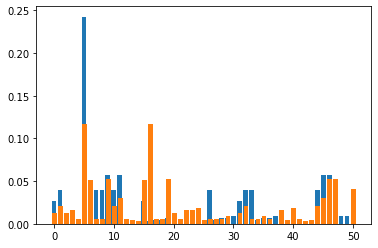

-27.948658985407924


In [21]:
plt.bar(np.arange(psi.shape[0]),psi.conjugate()*psi)
plt.bar(np.arange(psi.shape[0])+0.1,psi0[:,0].conjugate()*psi0[:,0])
plt.show()

print(psi.conjugate() @ NSMHamiltonian.hamiltonian @ psi)
